# Daria Bromot - FS500047

## Semi-Supervised Learning

In this exercise, we will work with methods for dimensionality reduction, clustering and machine learning for classification.  

We will start with the MNIST dataset, that includes images of 28x28 pixels of different digits, along with their true labels. Although the dataset is labeled, we will also use it to play with methods of unsupevised and semi-supervised learning.

First, let's import relevant packages and load the MNIST dataset.

In [111]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances
import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
from sklearn import metrics
from sklearn.metrics import homogeneity_score, completeness_score
from sklearn.metrics import mutual_info_score
from sklearn.metrics import silhouette_samples, silhouette_score, accuracy_score
import matplotlib.cm as cm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
import hdbscan

plt.rcParams["font.size"] = 14
plt.rcParams["axes.titlesize"] = 28
plt.rcParams["axes.labelsize"] = 24
plt.rcParams["figure.figsize"] = (20,12)

np.random.seed(0)

import warnings
warnings.filterwarnings("ignore")

In [112]:
mnist = fetch_openml('mnist_784')

In [113]:
dim = int(np.sqrt(len(mnist.data.columns))) # 28
X = mnist.data.values # data is pd.DataFrame
y = mnist.target.cat.codes.values # mnist.target is pd.Categorical

In [114]:
print(X.shape)
print(y.shape)
print(dim)

(70000, 784)
(70000,)
28


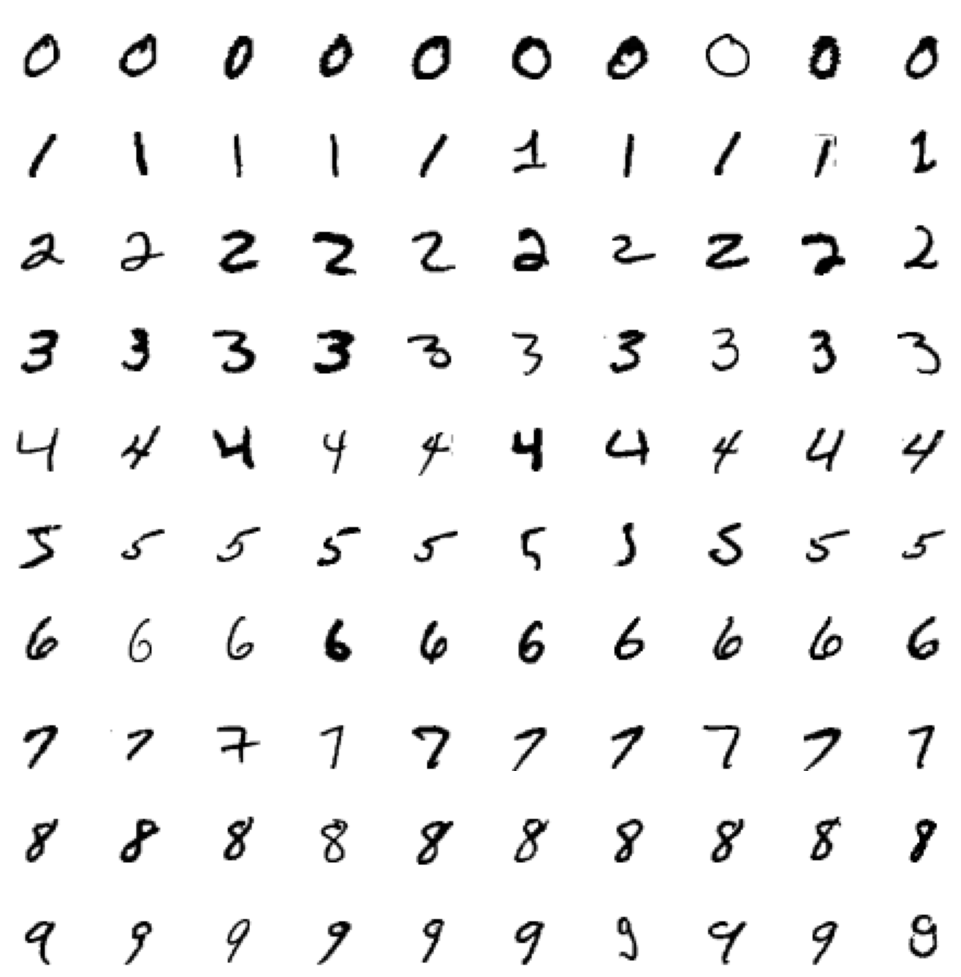

In [115]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10)) 
fig.subplots_adjust(hspace=0.1, wspace=0.1)

digit_counts = [0] * 10  

for digit in range(10):
    count = 0 
    
    while count < 10:
        digit_index = np.where(y == digit)[0][digit_counts[digit]]
        digit_image = X[digit_index].reshape((dim, dim))
        
        ax = axes[digit, count]
        ax.imshow(digit_image, cmap='gray_r') 
        ax.axis('off')
        ax.set_title(f"Digit: {digit}", fontsize=8, color='white') 
        ax.set_facecolor('white')  
        
        digit_counts[digit] += 1
        count += 1

plt.tight_layout()
plt.show()

On the first sign, I think we have a huge problem with number 1 and 7, it looks much similar

To speed things up, let's use a subset of the data, with 5,000 random points.

In [116]:
subset_size = 5000 

subset_indices = np.random.choice(len(X), size=subset_size, replace=False) 

subset_X = X[subset_indices]
subset_y = y[subset_indices]

In [117]:
X_train, X_test, y_train, y_test = train_test_split(subset_X, subset_y, test_size=0.2, random_state=0)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (4000, 784)
Test set shape: (1000, 784)


## Bonus: Semi-supervised Learning
Now, let's assume we only have labels for a small set of the images, but have the entire dataset available.  

Next we will use the entire unlabeled dataset to reduce dimensions and use the reduced dimensions as features to a classifier that uses a labeled set. We will plot the learning curve of such a classifier, varying the number of labeled dataset for training.

## Learning Curve: Logistic Regression on original data

First, evaluate the performance of a simple Logistic Regression classifier on the dataset, with increasing sizes of labeled datapoints used for training the model. Use the following sizes for the learning curve:

In [119]:
num_available_labeled_points = [20,50,100,120,150,200] + list(range(250,500,50)) + list(range(500,1000,100))
num_available_labeled_points

[20, 50, 100, 120, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900]

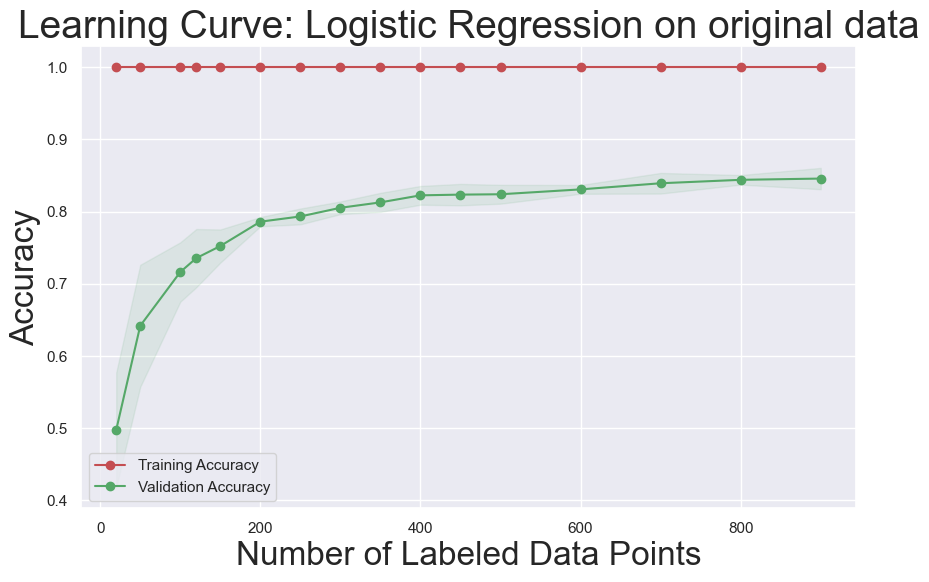

In [120]:
classifier = LogisticRegression()

train_sizes, train_scores, test_scores = learning_curve(
    classifier, X_train, y_train, train_sizes=num_available_labeled_points, cv=5, scoring='accuracy'
)

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve: Logistic Regression on original data")
plt.xlabel("Number of Labeled Data Points")
plt.ylabel("Accuracy")
plt.grid(True)
plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r"
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g"
)
plt.plot(
    train_sizes,
    train_scores_mean,
    'o-',
    color="r",
    label="Training Accuracy"
)
plt.plot(
    train_sizes,
    test_scores_mean,
    'o-',
    color="g",
    label="Validation Accuracy"
)
plt.legend(loc="best")
plt.show()


## Learning Curve: Logistic Regression with Partial Labelling and UMAP

We can mask some of the label information – we do this by using the sklearn standard of giving unlabelled points a label of -1

After we have masked some of the labels we can try to perform supervised learning again. Everything works as before, but UMAP will interpret the -1 label as being an unlabelled point and learn accordingly.

We can look at a scatterplot of the data colored by class.

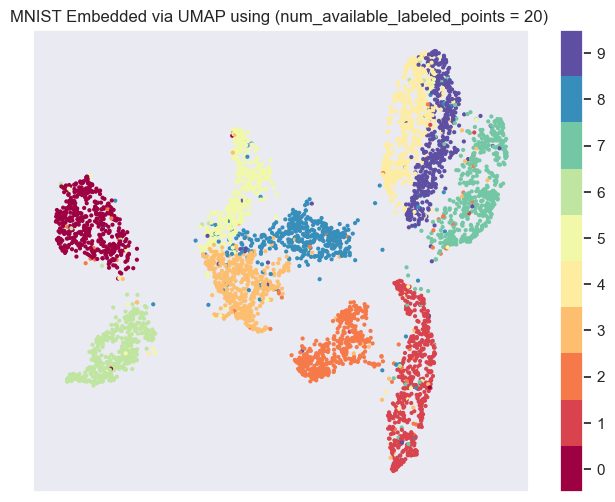

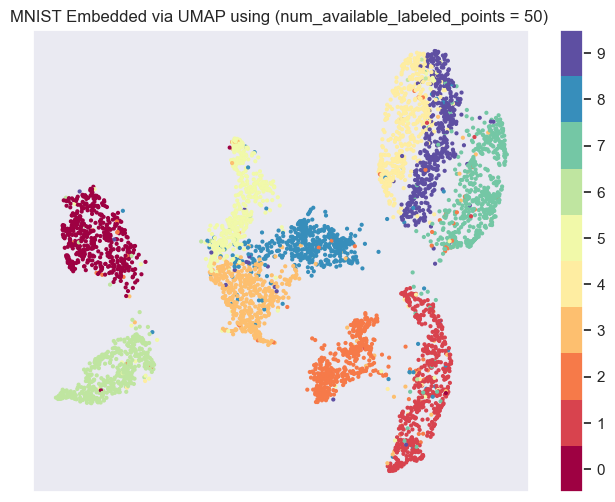

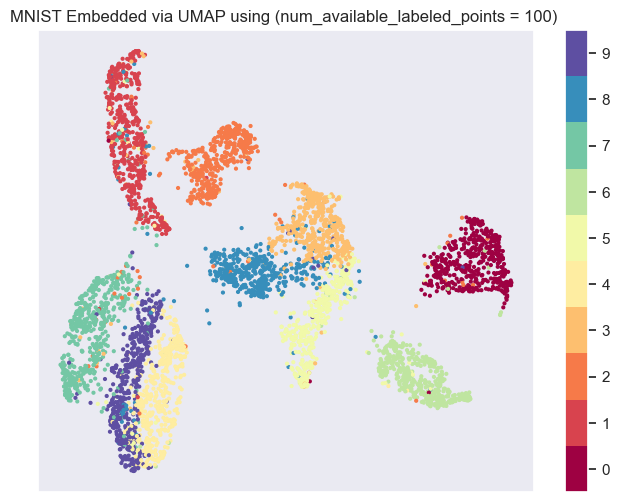

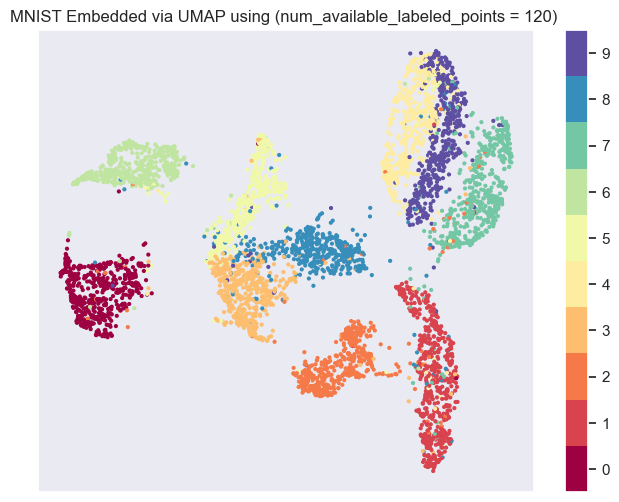

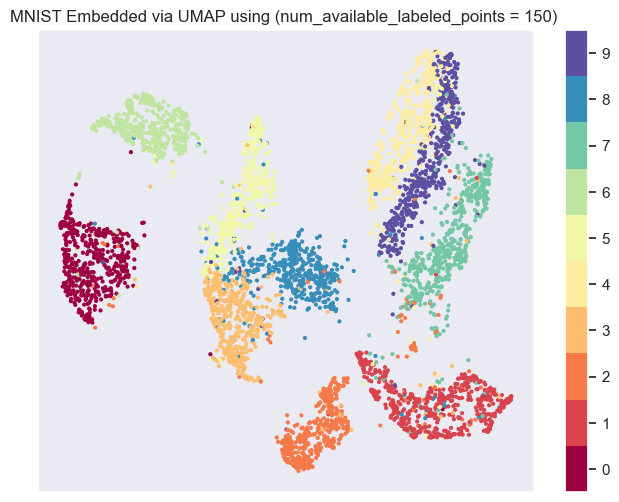

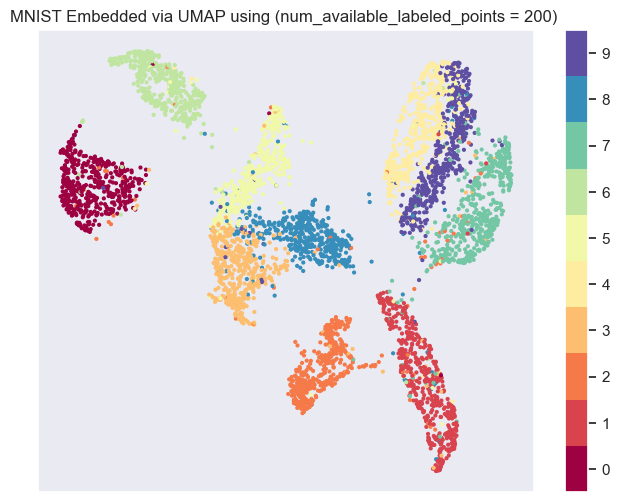

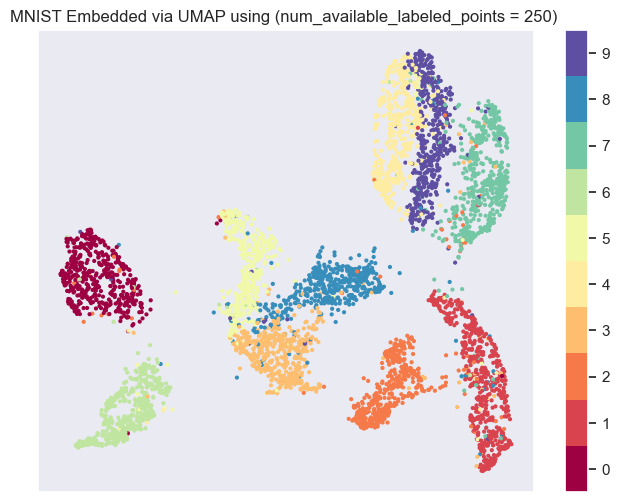

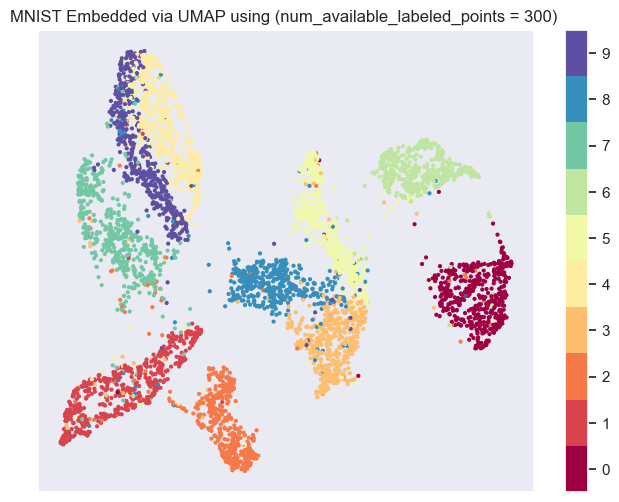

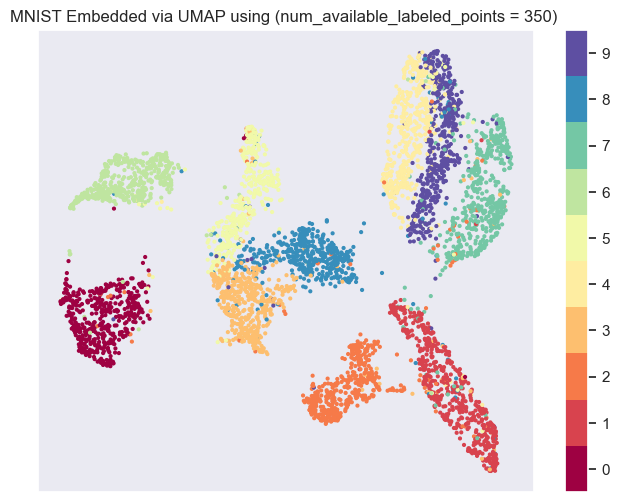

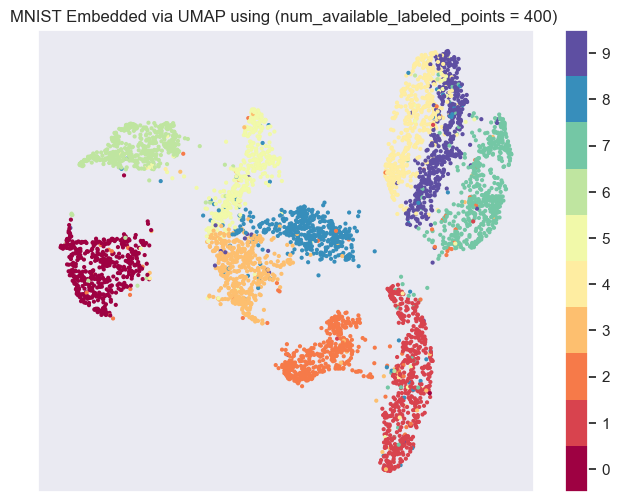

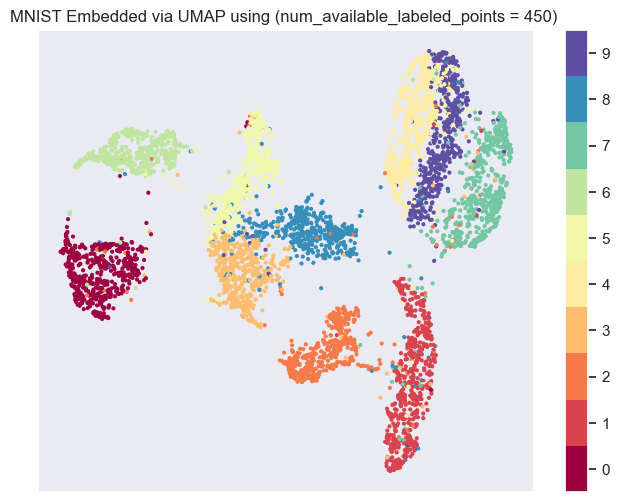

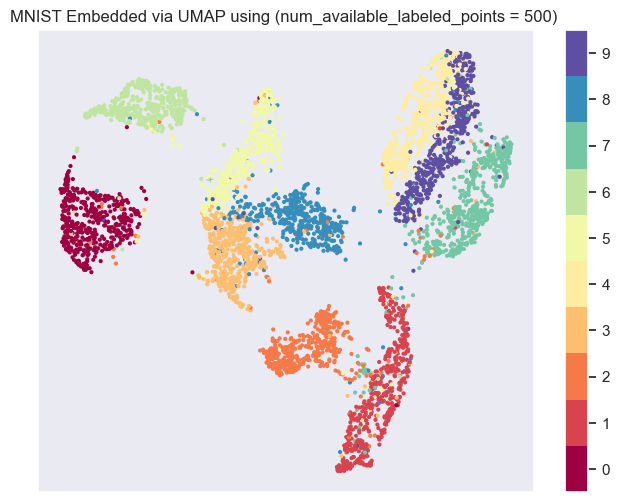

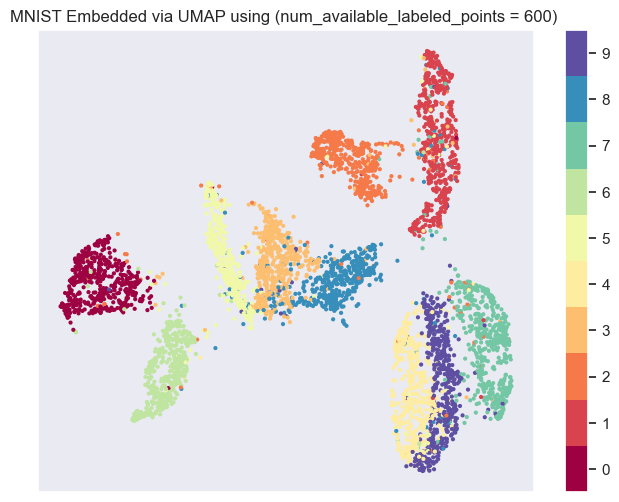

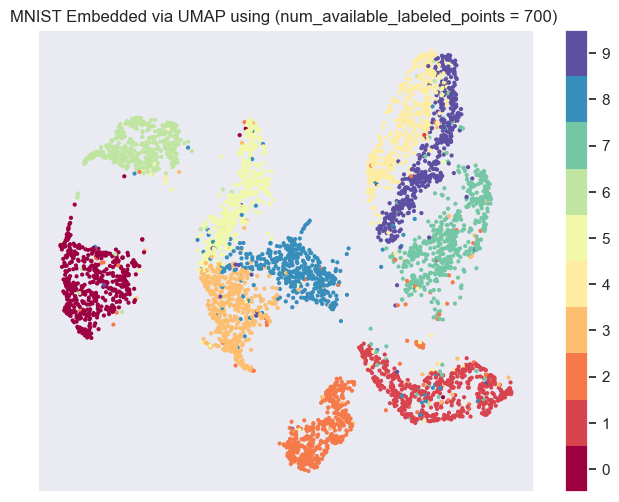

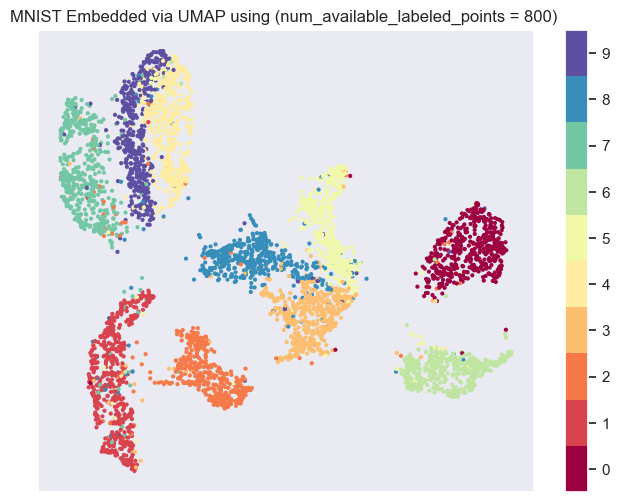

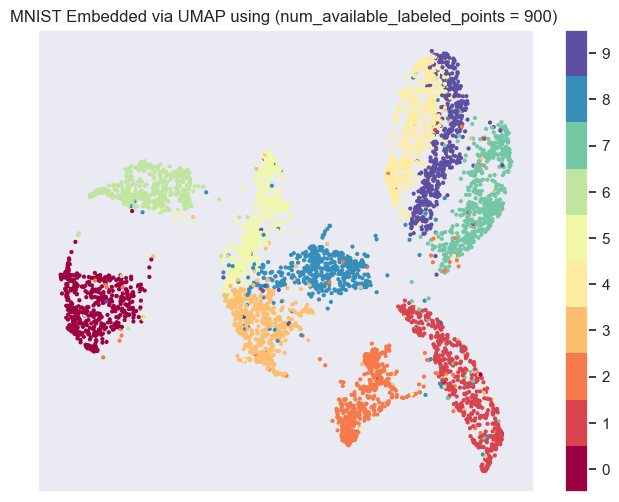

In [123]:
train_sizes = []
train_scores = []
test_scores = []
classification_reports = []

for num_points in num_available_labeled_points:
    subset_X_labeled = subset_X[:num_points]
    subset_y_labeled = subset_y[:num_points]
    subset_X_unlabeled = subset_X[num_points:]

    combined_X = np.concatenate((subset_X_labeled, subset_X_unlabeled))
    combined_y = np.concatenate((subset_y_labeled, np.full(len(subset_X_unlabeled), -1)))

    fitter = umap.UMAP().fit(combined_X, y=combined_y)
    embedding = fitter.embedding_
    
    fig, ax = plt.subplots(1, figsize=(8, 6))
    plt.scatter(*embedding.T, s=4, c=subset_y, cmap='Spectral', alpha=1.0)
    plt.setp(ax, xticks=[], yticks=[])
    cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
    cbar.set_ticks(np.arange(10))
    plt.title(f'MNIST Embedded via UMAP using (num_available_labeled_points = {num_points}) ', fontsize=12)
    plt.show()

    X_train, X_test, y_train, y_test = train_test_split(embedding, subset_y, test_size=0.2, random_state=0)
    
    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, y_pred)

    train_sizes.append(num_points)
    train_scores.append(train_accuracy)
    test_scores.append(test_accuracy)
    
    report = classification_report(y_test, y_pred)
    classification_reports.append(report)

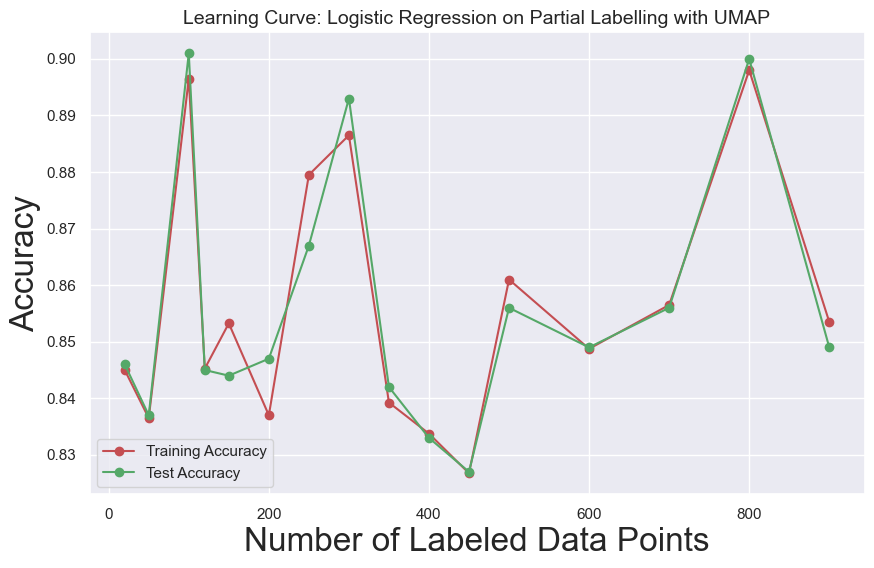

In [124]:
plt.figure(figsize=(10, 6))
plt.title('Learning Curve: Logistic Regression on Partial Labelling with UMAP',fontsize=14)
plt.xlabel('Number of Labeled Data Points')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(train_sizes, train_scores, 'o-', color='r', label='Training Accuracy')
plt.plot(train_sizes, test_scores, 'o-', color='g', label='Test Accuracy')
plt.legend(loc='best')
plt.show()

In [125]:
for i, num_points in enumerate(num_available_labeled_points):
    print(f"Classification Report for num_points = {num_points}:\n\n{classification_reports[i]}\n")

Classification Report for num_points = 20:

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       110
           1       0.86      0.99      0.92       115
           2       0.98      0.87      0.92       112
           3       0.91      0.86      0.88       102
           4       0.62      0.63      0.63        87
           5       0.86      0.87      0.87        70
           6       0.95      0.97      0.96        95
           7       0.82      0.88      0.85       120
           8       0.87      0.84      0.85        94
           9       0.56      0.51      0.53        95

    accuracy                           0.85      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.85      0.85      0.84      1000


Classification Report for num_points = 50:

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       110
           1       0.85      0.94      0.89

The result is much as we would expect – while we haven’t cleanly separated the data as we did in the totally supervised case, the classes have been made cleaner and more distinct. This semi-supervised approach provides a powerful tool when labelling is potentially expensive, or when you have more data than labels, but want to make use of that extra data.

## Learning Curve: Logistic Regression with Partial Labelling and UMAP after PCA

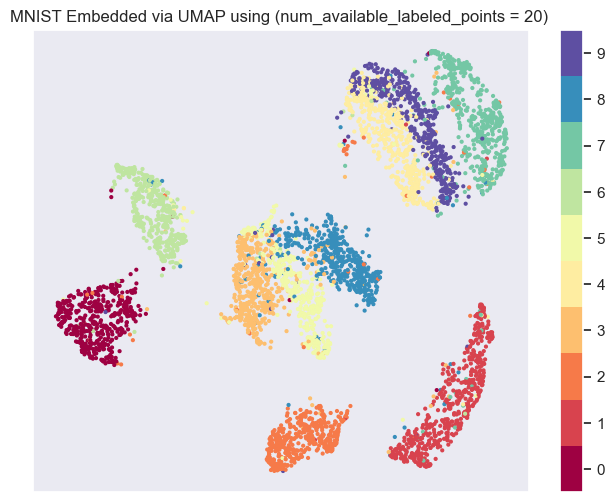

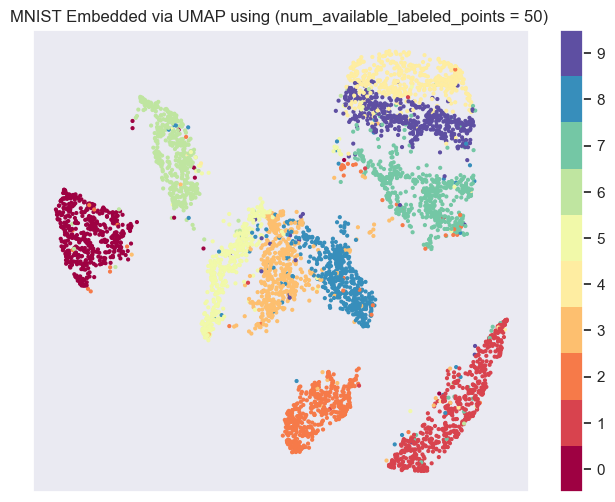

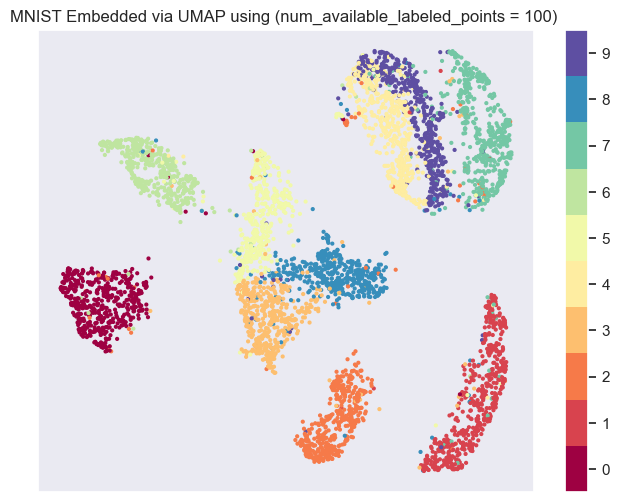

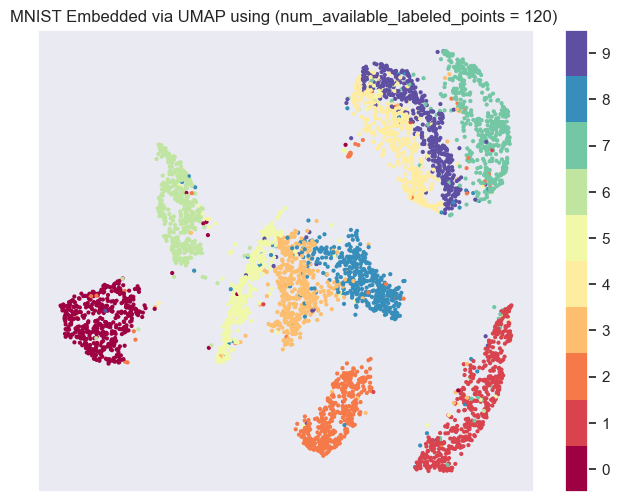

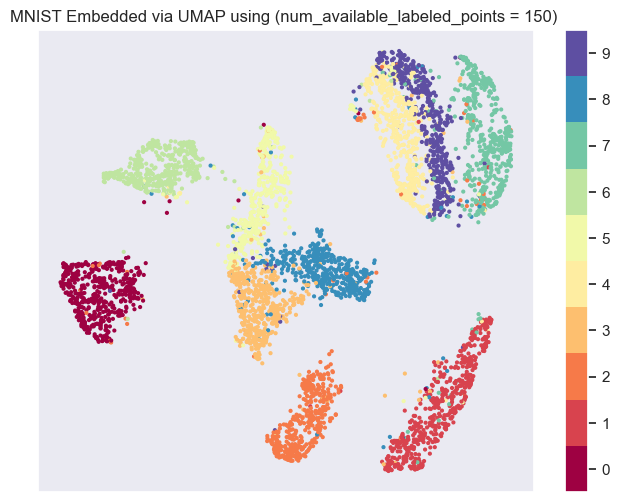

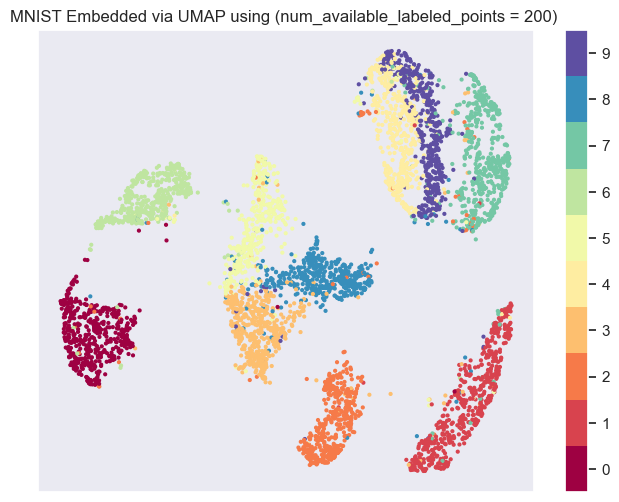

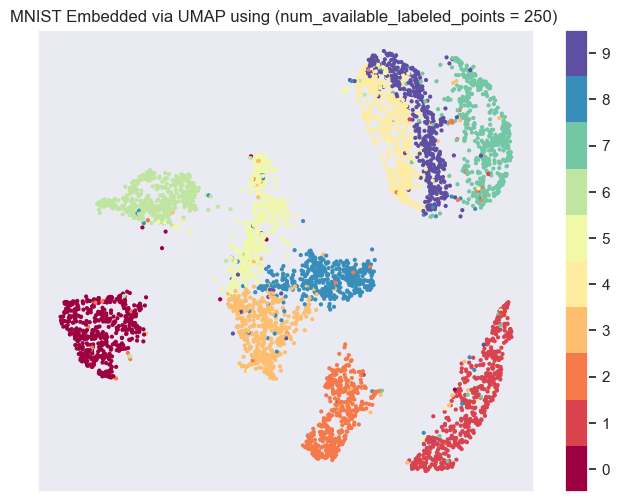

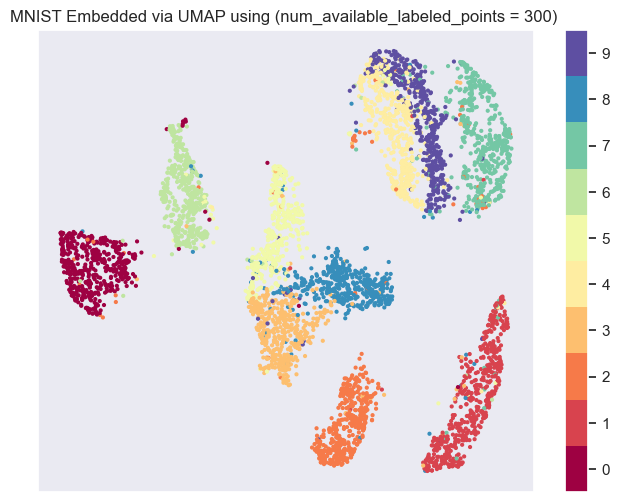

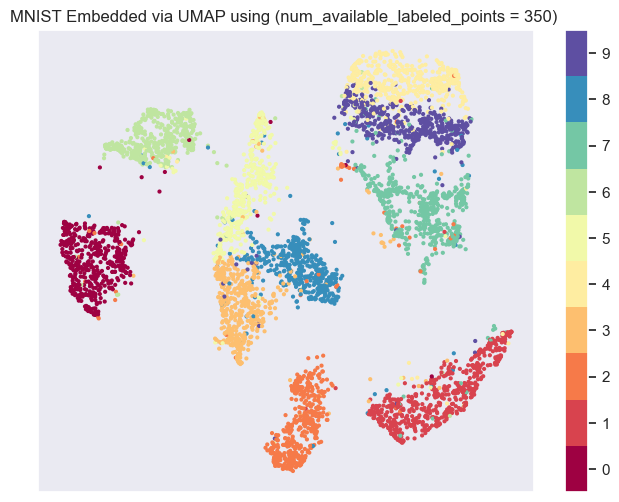

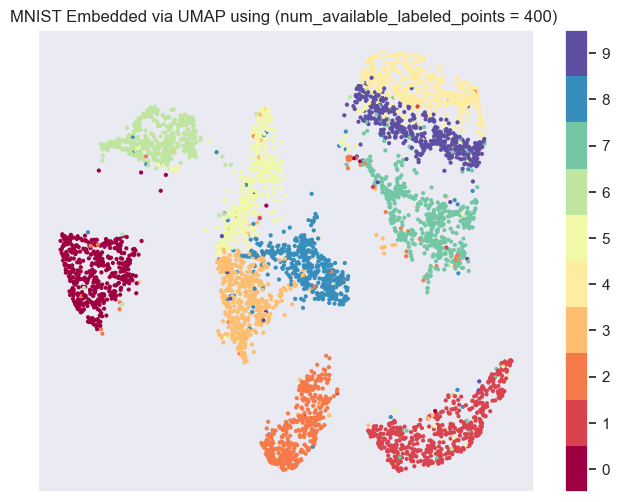

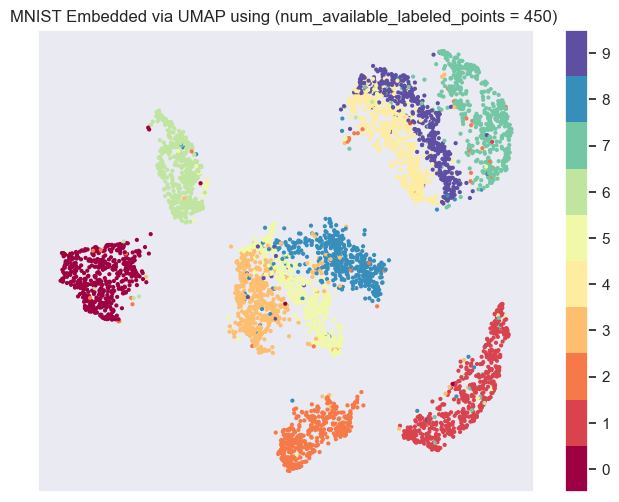

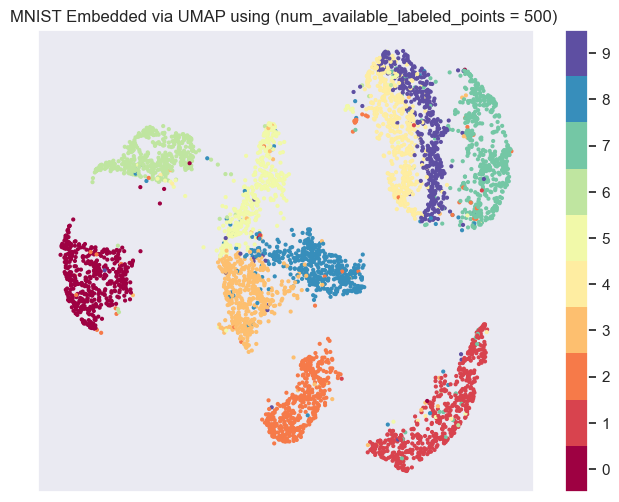

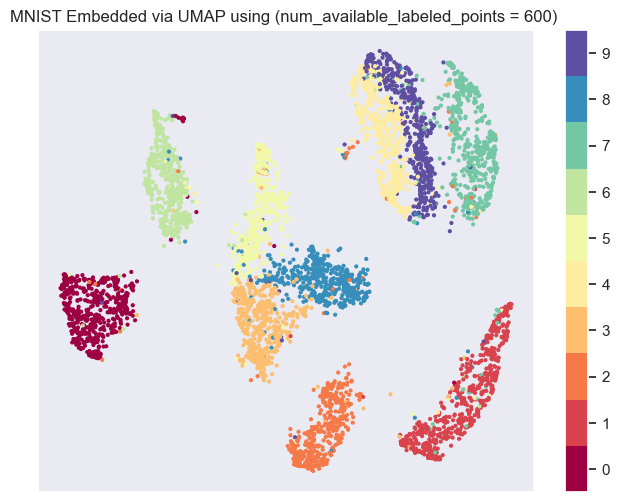

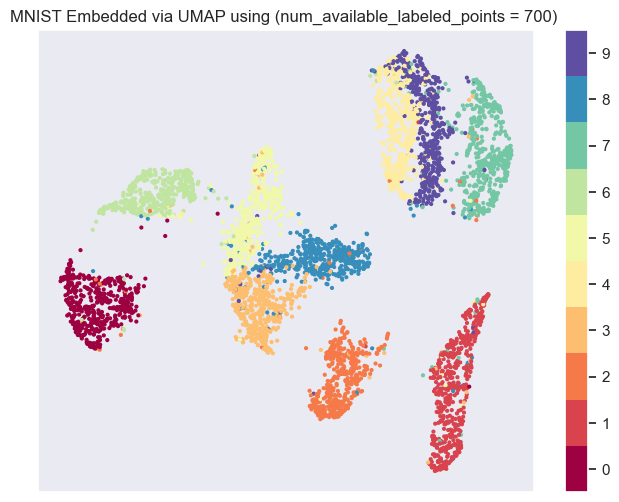

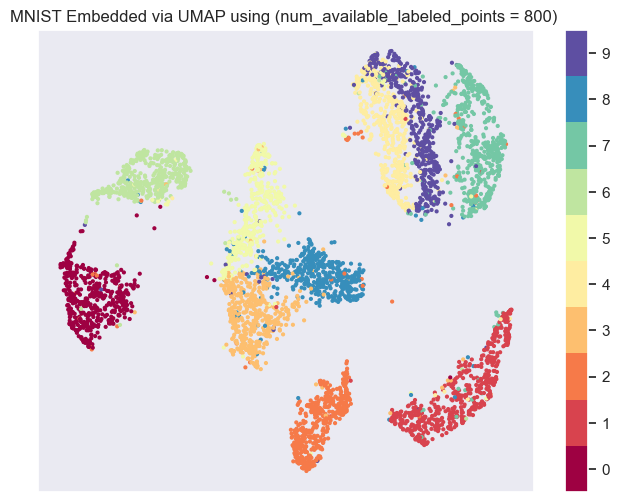

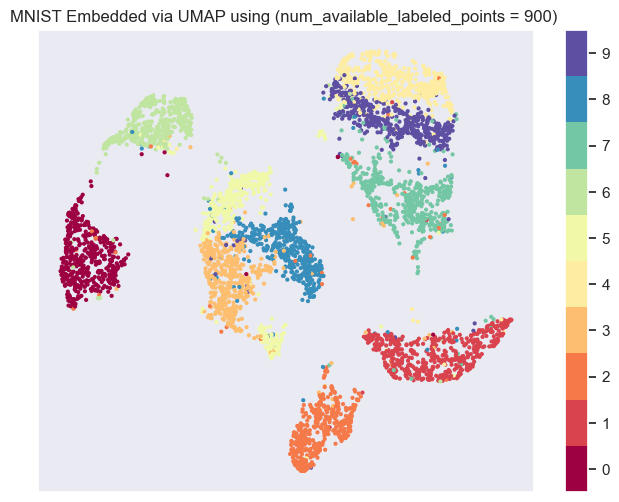

In [95]:
train_sizes = []
train_scores = []
test_scores = []
classification_reports = []

for num_points in num_available_labeled_points:
    subset_X_labeled = subset_X[:num_points]
    subset_y_labeled = subset_y[:num_points]
    subset_X_unlabeled = subset_X[num_points:]

    combined_X = np.concatenate((subset_X_labeled, subset_X_unlabeled))
    combined_y = np.concatenate((subset_y_labeled, np.full(len(subset_X_unlabeled), -1)))
    
    pca = PCA(n_components=50)
    X_pca = pca.fit_transform(combined_X)

    fitter = umap.UMAP().fit(X_pca, y=combined_y)
    embedding = fitter.embedding_
    
    fig, ax = plt.subplots(1, figsize=(8, 6))
    plt.scatter(*embedding.T, s=4, c=subset_y, cmap='Spectral', alpha=1.0)
    plt.setp(ax, xticks=[], yticks=[])
    cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
    cbar.set_ticks(np.arange(10))
    plt.title(f'MNIST Embedded via UMAP using (num_available_labeled_points = {num_points}) ',fontsize=12)
    plt.show()

    X_train, X_test, y_train, y_test = train_test_split(embedding, subset_y, test_size=0.2, random_state=0)
    
    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, y_pred)

    train_sizes.append(num_points)
    train_scores.append(train_accuracy)
    test_scores.append(test_accuracy)
    
    report = classification_report(y_test, y_pred)
    classification_reports.append(report)

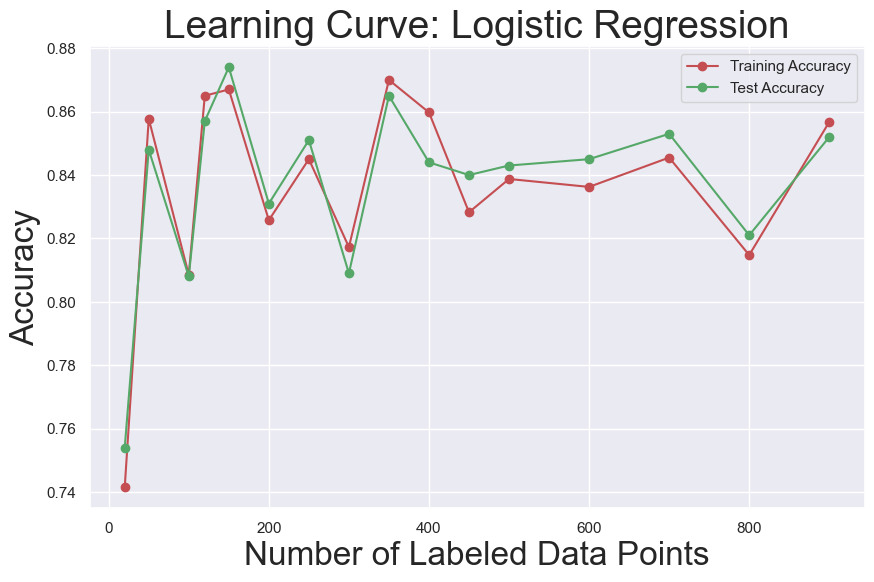

In [96]:
plt.figure(figsize=(10, 6))
plt.title('Learning Curve: Logistic Regression')
plt.xlabel('Number of Labeled Data Points')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(train_sizes, train_scores, 'o-', color='r', label='Training Accuracy')
plt.plot(train_sizes, test_scores, 'o-', color='g', label='Test Accuracy')
plt.legend(loc='best')
plt.show()

In [94]:
for i, num_points in enumerate(num_available_labeled_points):
    print(f"Classification Report for num_points = {num_points}:\n\n{classification_reports[i]}\n")

Classification Report for num_points = 20:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       110
           1       0.91      1.00      0.95       115
           2       0.97      0.89      0.93       112
           3       0.88      0.84      0.86       102
           4       0.70      0.66      0.67        87
           5       0.88      0.83      0.85        70
           6       0.96      0.98      0.97        95
           7       0.78      0.84      0.81       120
           8       0.88      0.88      0.88        94
           9       0.57      0.56      0.56        95

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000


Classification Report for num_points = 50:

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       110
           1       0.91      1.00      0.95

Based on the provided information, we have three models to consider:

1. Logistic Regression on original data: This model achieves an accuracy score ranging from 0.4975 to 0.84575. The accuracy tends to increase as more data points are used.

2. Logistic Regression with Partial Labelling and UMAP: This model utilizes partial labeling and UMAP dimensionality reduction technique. The accuracy scores range from 0.84 to 0.9, and the performance varies with the number of data points used.

3. Logistic Regression with Partial Labelling and UMAP after PCA: This model incorporates PCA (Principal Component Analysis) before applying partial labeling and UMAP. The accuracy scores range from 0.79 to 0.87, and the performance also varies with the number of data points.

Comparing the three models, it seems that the "Logistic Regression with Partial Labelling and UMAP" model performs the best overall. It consistently achieves high accuracy scores, with a maximum accuracy of 0.9. 